In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local').getOrCreate()

In [2]:
import os

df = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/data/DataSample.csv'))
df.printSchema()


root
 |-- _ID: integer (nullable = true)
 |--  TimeSt: timestamp (nullable = true)
 |-- Country: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [27]:
#### Problem 1: filtering out suspicious requests

df = df.dropDuplicates([' TimeSt', 'Country', 'Province', 'City', 'Latitude', 'Longitude'])

In [28]:
import math
from pyspark.sql.functions import stddev, avg

#### Problem 2: Assigning requests to closest POI

# DataFrame of POIs
poi = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/data/POIList.csv'))

# Removing suspicious POIs
poi = poi.dropDuplicates([' Latitude', 'Longitude'])

# POI class to help with assigning requests
class POI:
    def __init__(self, poi_id, latitude, longitude):
        self.poi_id = poi_id
        self.latitude = latitude
        self.longitude = longitude
        self.requests = []
        self.dataFrame = None
        self.std_dev = 0
        self.avg = 0
        self.radius = 0
        self.area = 0
        self.density = 0

poi_list = []

# Creating a list of POI objects
for row in poi.rdd.collect():
    poi_list.append(POI(row['POIID'], row[' Latitude'], row['Longitude']))

# Distance function
def distance(x1, x2, y1, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Assigning requests to the closest POI
for i, row in enumerate(df.rdd.collect()):
    distance_list = []
    request = {'id': row['_ID'], 'latitude': row['Latitude'], 'longitude': row['Longitude']}
    for poi in poi_list:
        distance_list.append(distance(request['latitude'], poi.latitude, request['longitude'], poi.longitude))
    min_distance = min(distance_list)
    request['distance'] = min_distance
    nearest_poi_index = distance_list.index(min_distance)
    nearest_poi = poi_list[nearest_poi_index]
    nearest_poi.requests.append(request)



In [31]:
#### PROBLEM 3 IS FROM THE DATA SCIENCE TRACK

#### Problem 3.1: For each POI, calculating average and standard deviation for the distance between POI and requests

# for each POI, creating a data frame of its requests, then calculating average and standard deviation using its data frame of requests

for poi in poi_list:
    poi.dataFrame = spark.createDataFrame(poi.requests)
    df_stats = poi.dataFrame.select(stddev('distance').alias('stddev'), avg('distance').alias('avg')).collect()
    poi.std_dev = df_stats[0]['stddev']
    poi.avg = df_stats[0]['avg']
    print("POIID:", poi.poi_id,"| standard deviation:", poi.std_dev,"| average:", poi.avg)
    

POIID: POI4 | standard deviation: 28.675130269811 | average: 8.810410862715715
POIID: POI3 | standard deviation: 2.8586897295404947 | average: 5.537950830488918
POIID: POI1 | standard deviation: 3.8584895715706744 | average: 3.3481830063255758


POIID: POI4 | radius: 192.7049913074258 | density (requests/area): 0.004148676408923476
POIID: POI3 | radius: 20.155377791591437 | density (requests/area): 7.692137385787865
POIID: POI1 | radius: 24.851937229893878 | density (requests/area): 4.998179064154918


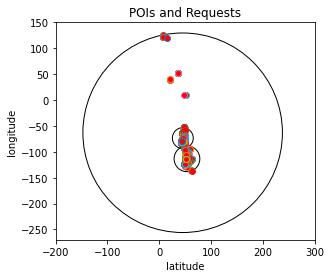

In [30]:
import matplotlib.pyplot as plt

#### Problem 3.2: Plotting POIs and their requests, calculating radius and density

figure, axes = plt.subplots()
for poi in poi_list:
    # Calculating radius
    poi.radius = poi.dataFrame.agg({"distance": "max"}).collect()[0]['max(distance)']
    
    # Calculating area
    poi.area = math.pi * (poi.radius)**2
    
    # Calculating density
    poi.density = len(poi.requests) / poi.area
    
    # Printing results
    print("POIID:", poi.poi_id, "| radius:", poi.radius, "| density (requests/area):", poi.density)
    
    # Drawing circle
    poi_circle = plt.Circle((poi.latitude, poi.longitude), poi.radius, fill=False)
    axes.add_patch(poi_circle)
    
    # Plotting requests
    for request in poi.requests:
        plt.plot(request['latitude'], request['longitude'], marker="o", markerfacecolor="red")
    
# Creating graph
axes.set_aspect(1)
axes.set_xlabel('latitude')
axes.set_ylabel('longitude')
plt.ylim(-270, 150)
plt.xlim(-200, 300)
plt.title('POIs and Requests')
plt.show()